# Example on how to use Python to read the output files from ASPECT.

We start by importing the packages needed and the functions from the file read_files.py:

In [1]:
%matplotlib inline  
## This allows figures to be plotted "inline". 
## In a normal python script, you use plt.show() to see the figures, 
## or plt.savefig("name.pdf") to save the figures 
## (you can also use this command in the notebooks)

import numpy as np  # for mathematical functions and arrays
import matplotlib.pyplot as plt  # for plot
import pandas as pd # for data analysis
## We use short names for the libraries we use a lot.

import io 
import os

import read_files

folder = "./example/"

# Parameter file

Sometimes, it's useful to be able to access the values for the parameters inside the parameter file, especially if you are exploring a large parameter space. 

You can read the parameter file with the function read_files.read_parameter_file(filename)

In [2]:
param_file = folder+"original.prm"
param = read_files.read_parameter_file(param_file)

The param variable is then a dictionnary that include all the parameters that have been defined in the original parameter file. One can then access the values using the same names than the subsections in the .prm file. 

In [3]:
print(param["Material model"])
print(param["Material model: Melt global"])

{'Model name': ['melt', 'global']}
{'Include melting and freezing': ['false'], 'Thermal conductivity': ['1.'], 'Reference solid density': ['2.'], 'Thermal expansion coefficient': ['0.'], 'Reference shear viscosity': ['1.e2'], 'Thermal viscosity exponent': ['0.'], 'Reference temperature': ['0'], 'Solid compressibility': ['0.'], 'Reference melt density': ['1.'], 'Reference permeability': ['1.'], 'Reference bulk viscosity': ['1.e2'], 'Exponential melt weakening factor': ['0.'], 'Thermal bulk viscosity exponent': ['0.'], 'Melt compressibility': ['0.'], 'Melt bulk modulus derivative': ['0.'], 'Reference melt viscosity': ['1']}


## File statistics

The file statistics regroup all the statistics for everytime steps. It can be a very long file, so pandas (a package for data analysis) is the best tool to open and read it. 
The number of columns depends on your run, and is indicated as comments at the beginning of the file. The function read_statistics() will first read the comments, extracts the names of the columns and then read the file with pd.read_csv(). 

Here, we use an example of a run with a 1D column. All the output files are in the folder ./example. 

In [4]:
# we provide the name for the file statistics:
statistics = folder+ "statistics"

# we read the file with our function:
data = read_files.read_statistics(statistics)

The output of the function is a pandas dataframe, where all datas are in a big table where the columns have human-readable names. We can have a look at the table wit data.head()

In [5]:
data.head()

,Time step number,Time (seconds),Time step size (seconds),Number of mesh cells,Number of Stokes degrees of freedom,Number of temperature degrees of freedom,Number of degrees of freedom for all compositions,Number of nonlinear iterations,Iterations for temperature solver,Iterations for composition solver 1,...,Schur complement iterations in Stokes preconditioner,Visualization file name,Minimal value for composition porosity,Maximal value for composition porosity,Global mass for composition porosity,RMS velocity (m/s),Max. velocity (m/s),Minimal temperature (K),Average temperature (K),Maximal temperature (K)
0,0,0.000000,0.00000,400,5608,2403,2403,2,0,0,...,796,example/solution/solution-00000,0.0,1.0,7.504167,0.577246,0.629878,0.0,0.0,0.0
1,1,0.085050,0.08505,400,5608,2403,2403,3,0,18,...,1215,NaN,0.0,1.0,7.504511,0.577315,0.629878,0.0,0.0,0.0
2,2,0.170101,0.08505,400,5608,2403,2403,3,0,19,...,821,NaN,0.0,1.0,7.504858,0.577396,0.629881,0.0,0.0,0.0
3,3,0.255151,0.08505,400,5608,2403,2403,3,0,19,...,854,NaN,0.0,1.0,7.505211,0.577489,0.629884,0.0,0.0,0.0
4,4,0.340201,0.08505,400,5608,2403,2403,3,0,19,...,888,NaN,0.0,1.0,7.505572,0.577596,0.629890,0.0,0.0,0.0


We can then look at the evolution of some of the statistics with time: 

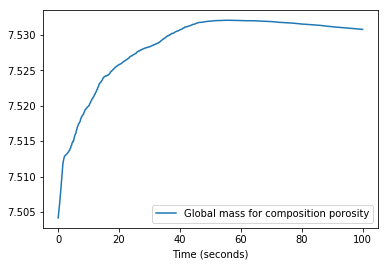

In [6]:
data.plot("Time (seconds)", "Global mass for composition porosity")

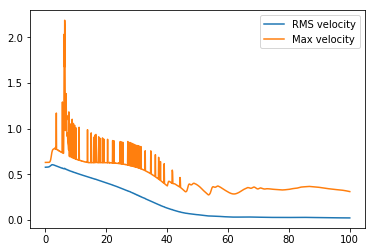

In [7]:
fig, ax = plt.subplots()

ax.plot(data["Time (seconds)"], data["RMS velocity (m/s)"], label="RMS velocity")
ax.plot(data["Time (seconds)"], data["Max. velocity (m/s)"], label="Max velocity")
ax.legend()

## Visualization files

The statistics file includes when visualization files have been created. If they have been written as gnuplot files, then we can read them and plot them. 

In the example case, the grid is a column of 1 cell width. So the output can be plotted as 1D variable. 

In [8]:
# we remove the values from data with NaN in the visualization file name column
data = data.dropna(subset=["Visualization file name"])

# we store the values for the file names and the associated time. 
visu_files = data["Visualization file name"].values
visu_times = data["Time (seconds)"].values

print(visu_files[0])

example/solution/solution-00000


(0, 100)

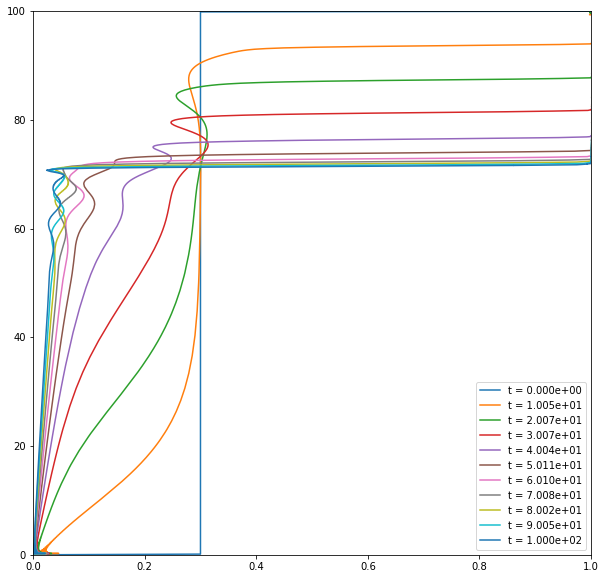

In [9]:
fig, ax = plt.subplots(figsize=[10,10])

for time, file in zip(visu_times, visu_files):
    #print(time, file)
    file = file+".0000.gnuplot"
    df = read_files.read_gnuplot_visu(file)
    #df = df[df["x"]==0.5]
    ax.plot(df["porosity"], df["y"], label="t = {:.3e}".format(time))

ax.legend()
ax.set_xlim([-0., 1.])
ax.set_ylim([0, 100])